### Read caffe weights and save them in numpy

In [1]:
# code to convert MSGNET from caffe to npy
import caffe
import argparse
import numpy as np
from collections import OrderedDict

In [2]:
# parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# parser.add_argument('--proto-path', type=str, default="./models/NYUV2/deploy.prototxt")
# parser.add_argument('--caffemodel-path', type=str, default="./models/NYUV2/cvpr_nyuv2.caffemodel")
# parser.add_argument('--output-path', type=str, default="./caffe_params.npy")
proto_path = "./models/NYUV2/deploy.prototxt"
caffemodel_path = "./models/NYUV2/cvpr_nyuv2.caffemodel"
npy_path = "./caffe_params_nyuv2.npy"

In [3]:
# args = parser.parse_args()
net = caffe.Net(proto_path, caffemodel_path, caffe.TRAIN)

layers = OrderedDict()
for name, params in net.params.items():
    layers[name] = {}
    # probably only works for DORN's caffe model...
    if "bn" in name: # batchnorm
        print("{} left: {}".format(name, len(params) - 4))
        layers[name]["scale"] = params[0].data
        layers[name]["shift"] = params[1].data
        layers[name]["mean"] = params[2].data
        layers[name]["var"] = params[3].data
    elif "ip" in name: # inner product (i.e. fully connected)
        print("{} left: {}".format(name, len(params) - 2))
        layers[name]["weight"] = params[0].data
        layers[name]["bias"] = params[1].data
    else: # convolution
        layers[name]["weight"] = params[0].data
        if len(params) == 2:
            print("{} left: {}".format(name, len(params) - 2))
            layers[name]["bias"] = params[1].data
        else:
            print("{} left: {}".format(name, len(params) - 1))
# Save layers to file
with open(npy_path, "w") as f:
    print("saving to {}".format(npy_path))
    np.save(f, layers)

conv1_1_3x3_s2 left: 0
conv1_1_3x3_s2/bn left: 0
conv1_2_3x3 left: 0
conv1_2_3x3/bn left: 0
conv1_3_3x3 left: 0
conv1_3_3x3/bn left: 0
conv2_1_1x1_reduce left: 0
conv2_1_1x1_reduce/bn left: 0
conv2_1_3x3 left: 0
conv2_1_3x3/bn left: 0
conv2_1_1x1_increase left: 0
conv2_1_1x1_increase/bn left: 0
conv2_1_1x1_proj left: 0
conv2_1_1x1_proj/bn left: 0
conv2_2_1x1_reduce left: 0
conv2_2_1x1_reduce/bn left: 0
conv2_2_3x3 left: 0
conv2_2_3x3/bn left: 0
conv2_2_1x1_increase left: 0
conv2_2_1x1_increase/bn left: 0
conv2_3_1x1_reduce left: 0
conv2_3_1x1_reduce/bn left: 0
conv2_3_3x3 left: 0
conv2_3_3x3/bn left: 0
conv2_3_1x1_increase left: 0
conv2_3_1x1_increase/bn left: 0
conv3_1_1x1_reduce left: 0
conv3_1_1x1_reduce/bn left: 0
conv3_1_3x3 left: 0
conv3_1_3x3/bn left: 0
conv3_1_1x1_increase left: 0
conv3_1_1x1_increase/bn left: 0
conv3_1_1x1_proj left: 0
conv3_1_1x1_proj/bn left: 0
conv3_2_1x1_reduce left: 0
conv3_2_1x1_reduce/bn left: 0
conv3_2_3x3 left: 0
conv3_2_3x3/bn left: 0
conv3_2_1x1_inc

### Load numpy file and pytorch network

In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
npy_path = "./caffe_params_nyuv2.npy"
torch_path = "./torch_params_nyuv2.pth.tar"
layers = np.load(npy_path)
layers = layers[()] # Weird indexing thing
# print(layers['ip1/depth']["weight"].shape)
# print(layers["conv1_1_3x3_s2/bn"].keys())
new_layers = {}
for key in layers:
    new_key = key.replace("/", "_")
    new_layers[new_key] = layers[key]
layers = new_layers

In [3]:
# Specific to DORN
state_dict = {}
for layer_name in layers:
    if "bn" in layer_name: # Batchnorm
        state_dict[layer_name + ".weight"] = torch.from_numpy(layers[layer_name]["scale"].flatten())
        state_dict[layer_name + ".bias"] = torch.from_numpy(layers[layer_name]["shift"].flatten())
        state_dict[layer_name + ".running_mean"] = torch.from_numpy(layers[layer_name]["mean"].flatten())
        state_dict[layer_name + ".running_var"] = torch.from_numpy(layers[layer_name]["var"].flatten())
    elif "ip" in layer_name: # inner product
        state_dict[layer_name + ".weight"] = torch.from_numpy(layers[layer_name]["weight"])
        state_dict[layer_name + ".bias"] = torch.from_numpy(layers[layer_name]["bias"])
    else:
        state_dict[layer_name + ".weight"] = torch.from_numpy(layers[layer_name]["weight"])
        if len(layers[layer_name]) == 2:
            state_dict[layer_name + ".bias"] = torch.from_numpy(layers[layer_name]["bias"])
#             print(layer_name, layers[layer_name]["weight"].shape)
#             print(layers[layer_name]["bias"].shape)
        else:
            pass
#             print(layer_name, layers[layer_name]["weight"].shape)
#             state_dict[layer_name + ".bias"] = torch.zeros(layers[layer_name]["weight"].shape[0])

In [4]:
from DORN_pytorch import DORN_nyu

In [5]:
net = DORN_nyu()

In [6]:
net.load_state_dict(state_dict)

In [7]:
torch.save(net.state_dict(), torch_path)

### Test the loaded network

In [1]:
import torch
import torchvision.transforms as transforms
from DORN_pytorch import DORN_nyu
from PIL import Image
import numpy as np
import cv2

def decode_ord(data_pytorch):
    """Takes a pytorch tensor, converts to numpy, then
    does the ordinal loss decoding.
    """
    data = data_pytorch.numpy()
    N = data.shape[0]
    C = data.shape[1]
    H = data.shape[2]
    W = data.shape[3]
#     ord_labels = bottom[0].data.copy()
    ord_labels = data
    decode_label = np.zeros((N, 1, H, W), dtype=np.float32)
    ord_num = C/2
    for i in range(int(ord_num)):
        ord_i = ord_labels[:,2*i:2*i+2,:,:]
        decode_label = decode_label + np.argmax(ord_i, axis=1)
    return decode_label.astype(np.float32, copy=False)

def convert_to_uint8(img, min_val, max_val):
    return np.uint8((img - min_val)/(max_val - min_val)*255.0)

In [2]:
# DORN-specific preprocessing
img_file = "./data/NYUV2/demo_01.png"
out_file = "./result/NYUV2/pytorch/out_01.png"
pixel_means = torch.tensor([103.0626, 115.9029, 123.1516]).unsqueeze(-1).unsqueeze(-1)
# print(pixel_means)
transform = transforms.Compose([
    transforms.Resize((257, 353)), # (Height, Width)
#     transforms.ToTensor()
])
rgb_pil = Image.open(img_file)
# print("pil", rgb_pil.getpixel((6, 7)))
H, W = rgb_pil.size
# print(H,W)
rgb_pil = transform(rgb_pil)
rgb_torch = np.array(rgb_pil)
print("pil", rgb_torch[7, 6])
print("pil", rgb_torch.shape)
# rgb_torch = np.array(rgb_torch) - np.array([[[103.0626, 115.9029, 123.1516]]])
# rgb = rgb.unsqueeze(0)

rgb_cv2 = cv2.imread(img_file, cv2.IMREAD_COLOR)
rgb_cv2 = rgb_cv2.astype(np.float32)
rgb_cv2 = rgb_cv2 - np.array([[[103.0626, 115.9029, 123.1516]]]).astype(np.float32)
# rgb_np -= np.array([[[103.0626, 115.9029, 123.1516]]])
rgb_cv2 = cv2.resize(rgb_cv2, (353, 257), interpolation=cv2.INTER_LINEAR)
print("cv2", rgb_cv2[7, 6])
print("cv2", rgb_cv2.shape)

rgb = torch.from_numpy(rgb_cv2.transpose(2,0,1)).unsqueeze(0)
print(rgb[0, :, 6, 7])

('pil', array([55, 32, 36], dtype=uint8))
('pil', (257, 353, 3))
('cv2', array([-67.25455, -83.9029 , -68.35469], dtype=float32))
('cv2', (257, 353, 3))
tensor([-71.9469, -85.1651, -69.0539])


In [3]:
torch_path = "./torch_params_nyuv2.pth.tar"
net = DORN_nyu()
net.load_state_dict(torch.load(torch_path))
net.eval();

In [4]:
with torch.no_grad():
    pytorch_probs = net(rgb)

('input', torch.Size([1, 3, 257, 353]))
('conv1', torch.Size([1, 128, 65, 89]))
('conv2', torch.Size([1, 256, 65, 89]))
('conv3', torch.Size([1, 512, 33, 45]))
('conv4', torch.Size([1, 1024, 33, 45]))
('before avg pool', torch.Size([1, 2048, 33, 45]))
('after', torch.Size([1, 2048, 5, 6]))
torch.Size([1, 2048, 5, 6])
('before zoom', torch.Size([1, 136, 33, 45]))


/home/markn1/anaconda3/envs/caffe/lib/python2.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [5]:
pytorch_probs.size()

torch.Size([1, 136, 257, 353])

In [6]:
decoded = decode_ord(pytorch_probs)

In [7]:
pred = decoded
pred = pred[0,0,:,:] - 1.0 #offset = 1
pred = pred/25.0 - 0.36
pred = np.exp(pred)
ord_score = cv2.resize(pred, (H, W), interpolation=cv2.INTER_LINEAR)
min_depth = 0.
max_depth = 10.
depth_img = convert_to_uint8(ord_score, min_depth, max_depth)

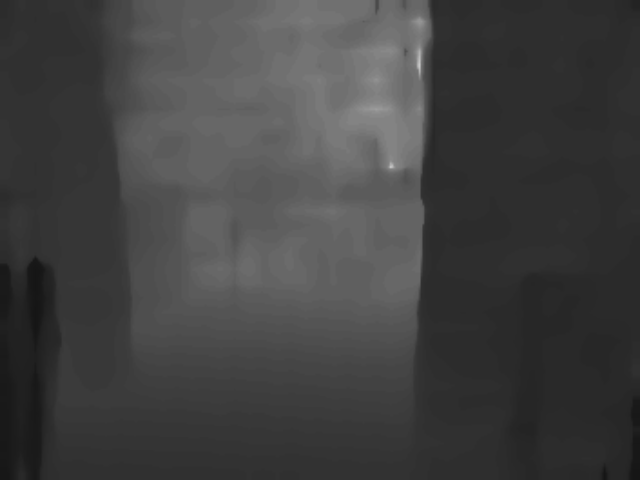

In [8]:
Image.fromarray(depth_img)

In [9]:
import caffe

def depth_prediction(filename, net, pixel_means):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    img = img.astype(np.float32)
    H = img.shape[0]
    W = img.shape[1]
    img -= pixel_means
    img = cv2.resize(img, (353, 257), interpolation=cv2.INTER_LINEAR)
    data = img.copy()
    data = data[None, :]
    data = data.transpose(0,3,1,2)
    blobs = {}
    blobs['data'] = data
    net.blobs['data'].reshape(*(blobs['data'].shape))
    forward_kwargs = {'data': blobs['data'].astype(np.float32, copy=False)}
#     print(forward_kwargs["data"][0, :, 6, 7])
    net.forward(**forward_kwargs)

#     pred = net.blobs['conv3_out'].data.copy()
#     pred = net.blobs['decode_ord'].data.copy()
#     pred = net.blobs['log_probs'].data.copy()
#     pred = net.blobs['resnet'].data.copy()
#     pred = net.blobs['conv1_1_3x3_s2'].data.copy()
#     return pred, data
###
    pred = net.blobs['decode_ord'].data.copy()
    pred = pred[0,0,:,:] - 1.0
    pred = pred/25.0 - 0.36
    pred = np.exp(pred)
    ord_score = cv2.resize(pred, (W, H), interpolation=cv2.INTER_LINEAR)
    return ord_score, net.blobs
# Load the original network in caffe to check
caffe_net = caffe.Net('models/NYUV2/deploy.prototxt', 'models/NYUV2/cvpr_nyuv2.caffemodel', caffe.TEST)

caffe_pred, blobs = depth_prediction(img_file, caffe_net, np.array([[[103.0626, 115.9029, 123.1516]]]))


In [32]:
# Verifying that layer outputs are the same
eps = 5e-4
print((np.abs(blobs['pool1_3x3_s2'].data - net.conv1_out.numpy()) <= eps).all())
print((np.abs(blobs['conv2_3'].data - net.conv2_out.numpy()) <= eps).all())
print((np.abs(blobs['conv3_4'].data - net.conv3_out.numpy()) <= eps).all())
print((np.abs(blobs['conv4_4'].data - net.conv4_4_out.numpy()) <= eps).all())
print((np.abs(blobs['conv4_8'].data - net.conv4_8_out.numpy()) <= eps).all())
print((np.abs(blobs['conv4_12'].data - net.conv4_12_out.numpy()) <= eps).all())
print((np.abs(blobs['conv4_16'].data - net.conv4_16_out.numpy()) <= eps).all())
print((np.abs(blobs['conv4_20'].data - net.conv4_20_out.numpy()) <= eps).all())
print((np.abs(blobs['conv4_23'].data - net.conv4_23_out.numpy()) <= eps).all())
print((np.abs(blobs['conv6_1'].data - net.encoder_out.numpy()) <= eps).all())
print((np.abs(blobs['conv6_2'].data - net.aspp2_out.numpy()) <= eps).all())
print((np.abs(blobs['conv6_3'].data - net.aspp3_out.numpy()) <= eps).all())
print((np.abs(blobs['conv6_4'].data - net.aspp4_out.numpy()) <= eps).all())
print((np.abs(blobs['conv6_5'].data - net.aspp5_out.numpy()) <= eps).all())
print(blobs['conv6_5'].data[0,8,0,0])
print(net.aspp.numpy()[0,8,0,0])
# print(net.)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
0.0


AttributeError: 'DORN_nyu' object has no attribute 'aspp'

In [20]:
blobs.keys()

['data',
 'conv1_1_3x3_s2',
 'conv1_2_3x3',
 'conv1_3_3x3',
 'pool1_3x3_s2',
 'pool1_3x3_s2_pool1_3x3_s2_0_split_0',
 'pool1_3x3_s2_pool1_3x3_s2_0_split_1',
 'conv2_1_1x1_reduce',
 'conv2_1_3x3',
 'conv2_1_1x1_increase',
 'conv2_1_1x1_proj',
 'conv2_1',
 'conv2_1_conv2_1/relu_0_split_0',
 'conv2_1_conv2_1/relu_0_split_1',
 'conv2_2_1x1_reduce',
 'conv2_2_3x3',
 'conv2_2_1x1_increase',
 'conv2_2',
 'conv2_2_conv2_2/relu_0_split_0',
 'conv2_2_conv2_2/relu_0_split_1',
 'conv2_3_1x1_reduce',
 'conv2_3_3x3',
 'conv2_3_1x1_increase',
 'conv2_3',
 'conv2_3_conv2_3/relu_0_split_0',
 'conv2_3_conv2_3/relu_0_split_1',
 'conv3_1_1x1_reduce',
 'conv3_1_3x3',
 'conv3_1_1x1_increase',
 'conv3_1_1x1_proj',
 'conv3_1',
 'conv3_1_conv3_1/relu_0_split_0',
 'conv3_1_conv3_1/relu_0_split_1',
 'conv3_2_1x1_reduce',
 'conv3_2_3x3',
 'conv3_2_1x1_increase',
 'conv3_2',
 'conv3_2_conv3_2/relu_0_split_0',
 'conv3_2_conv3_2/relu_0_split_1',
 'conv3_3_1x1_reduce',
 'conv3_3_3x3',
 'conv3_3_1x1_increase',
 'conv3

In [18]:
# Verifying that the inputs are the same
# caffe_pred[0,0,0,0]
print(img[0,:,44, 86])
print(rgb[0, :, 44, 86])

[24.25188   -3.4752297  8.0227165]
tensor([24.2519, -3.4752,  8.0227])


In [19]:
net.conv3_out[0,0,0,0]

tensor(16.7508)

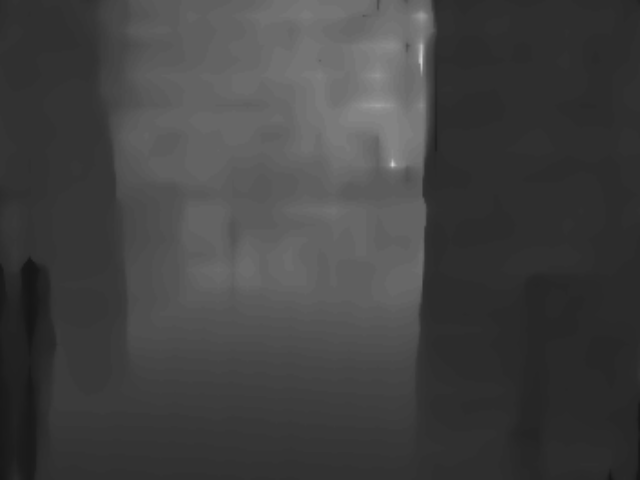

In [23]:
caffe_img = convert_to_uint8(caffe_pred, 0., 10.)
Image.fromarray(caffe_img)

368154
333870


In [ ]:
pytorch_probs[0,0,0,7]

In [5]:
import torch.nn.functional as F

In [8]:
test = torch.ones(5, 5).unsqueeze(0).unsqueeze(0)

In [17]:
F.avg_pool2d(test, kernel_size=2, ceil_mode=True)

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

In [37]:
rgb[0,0,0,1].numpy().tolist()

151.93740844726562

In [36]:
img[0,0,0,1].tolist()

151.93739318847656

In [38]:
(img - rgb.numpy())**2

array([[[[9.3132257e-10, 2.3283064e-10, 2.3283064e-10, ...,
          2.3283064e-10, 2.3283064e-10, 2.3283064e-10],
         [9.3132257e-10, 2.3283064e-10, 2.3283064e-10, ...,
          2.3283064e-10, 2.3283064e-10, 2.3283064e-10],
         [9.3132257e-10, 2.3283064e-10, 2.3283064e-10, ...,
          2.3283064e-10, 2.3283064e-10, 2.3283064e-10],
         ...,
         [9.3132257e-10, 2.3283064e-10, 2.3283064e-10, ...,
          2.3283064e-10, 2.3283064e-10, 2.3283064e-10],
         [9.3132257e-10, 2.3283064e-10, 2.3283064e-10, ...,
          2.3283064e-10, 2.3283064e-10, 2.3283064e-10],
         [9.3132257e-10, 2.3283064e-10, 2.3283064e-10, ...,
          2.3283064e-10, 2.3283064e-10, 2.3283064e-10]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, .

151.9373779296875